In [257]:
!pip install river
!pip install seaborn

In [258]:
#from google.colab import drive
#drive.mount('/content/drive')

In [261]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from river import datasets
from river import compose
from river import linear_model
from river import metrics
from river import evaluate
from river import preprocessing
from river import optim
from river import feature_extraction
from river import stats
from river import ensemble
from river import neighbors, stream, tree
from matplotlib import gridspec
from river import stream
import numpy as np
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
import datetime as dt

In [262]:
#from google.colab import files
#uploaded = files.upload()
df = pd.read_csv('https://raw.githubusercontent.com/eugenursu99/PS/main/sns_df.csv', sep=',',parse_dates=['Acquisition_Time'])
df.head()


,Unnamed: 0,Acquisition_Time,Hospital,Urgency_Type,Service,Emergency_Stage,Waiting_Time,People_Waiting,H_Name
0,0,2017-11-15 00:01:00,211,Urgncia Polivalente,Espera: Medicina Interna,4,17,0,S Jose
1,1,2017-11-15 00:01:00,211,Urgncia Polivalente,Espera: Medicina Interna,3,34,0,S Jose
2,2,2017-11-15 00:01:00,211,Urgncia Polivalente,Espera: Cirurgia Geral,3,6,0,S Jose
3,3,2017-11-15 00:01:00,211,Urgncia Polivalente,Espera: Oftalmologia,3,5,0,S Jose
4,4,2017-11-15 00:01:00,211,Urgncia Polivalente,Espera: Medicina Interna,2,309,8,S Jose


In [263]:
df.shape

(1048575, 9)

In [264]:
level5 = df.loc[(df['Emergency_Stage']==5) & (df['H_Name']=='Santa Maria')]
level5.count()

Unnamed: 0          60
Acquisition_Time    60
Hospital            60
Urgency_Type        60
Service             60
Emergency_Stage     60
Waiting_Time        60
People_Waiting      60
H_Name              60
dtype: int64

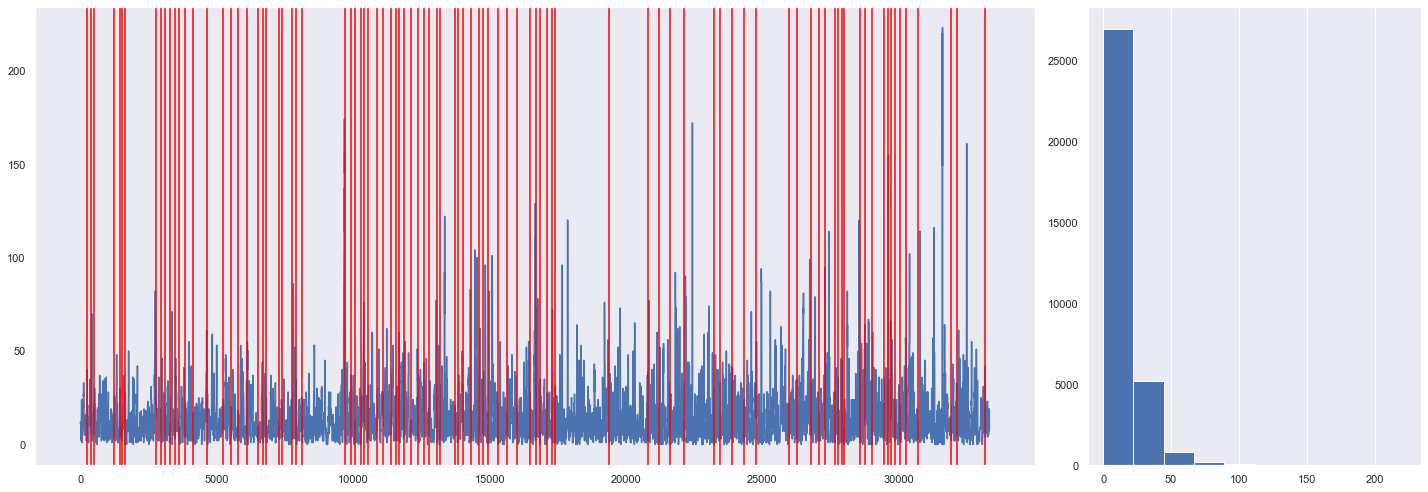

In [265]:
from river import drift

drift_detector = drift.ADWIN(delta = 0.00000001)
drifts = []

df2=df.loc[df['H_Name']=='Santa Maria']
df2.reset_index(drop=True, inplace=True)
#from pathlib import Path  
#filepath = Path('D:\\Eugen\\Universidade\\4º Ano\\2º Semestre\\PS\\PS\\santamaria.csv')  
#filepath.parent.mkdir(parents=True, exist_ok=True)  
#df2.to_csv(filepath) 
df3 = df2.loc[(df2['Service'] =='Medicina') ]
df3.reset_index(drop=True, inplace=True)
df4 = df3.loc[(df3['Emergency_Stage']==4) | (df3['Emergency_Stage']==5)]
df4.reset_index(drop=True, inplace=True)
df5=df4[['Emergency_Stage','People_Waiting','Waiting_Time']].copy()

y = df5.pop('Waiting_Time')

for i, val in enumerate(y):
    drift_detector.update(val)   # Data is processed one sample at a time
    if drift_detector.change_detected:
        # The drift detector indicates after each sample if there is a drift in the data
        #print(f'Change detected at index {i}')
        drifts.append(i)
        drift_detector.reset()   # As a best practice, we reset the detector


# Auxiliary function to plot the data
def plot_data(x, drifts=None):
    fig = plt.figure(figsize=(20,7), tight_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])
    ax1.grid()
    ax1.plot(y, label='Stream')
    ax2.grid(axis='y')
    ax2.hist(x, label=r'$x$')
    if drifts is not None:
        for drift_detected in drifts:
            ax1.axvline(drift_detected, color='red')
    plt.show()

plot_data(y, drifts)

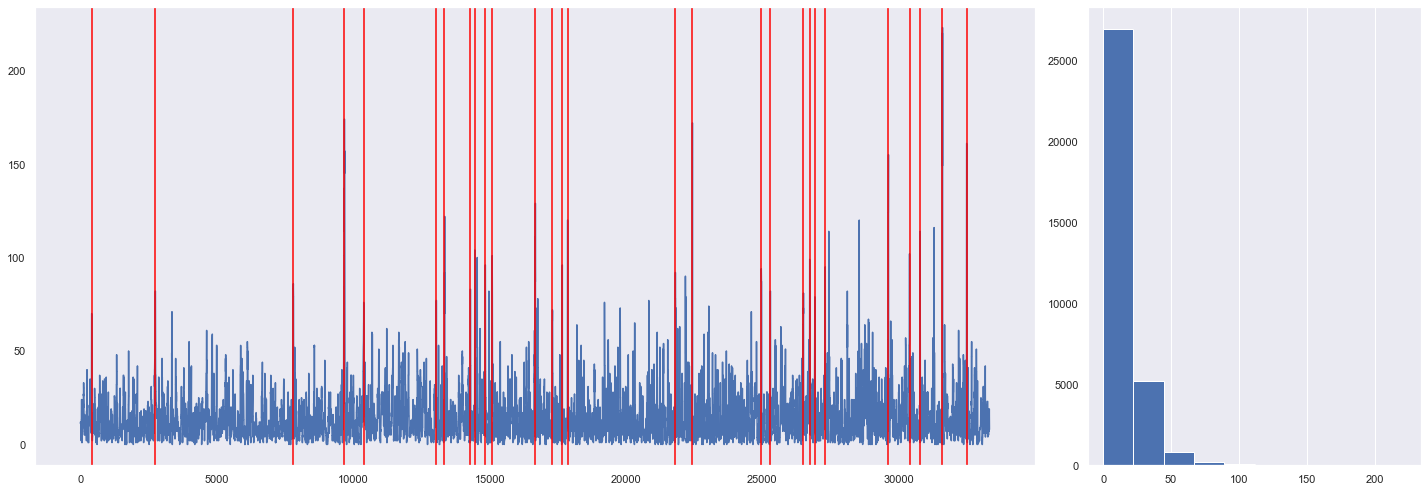

In [266]:
hinkley = drift.PageHinkley(min_instances = 50, delta = 0.00000001, threshold = 400, alpha  = 0.9)
drifts =[]

for i, val in enumerate(y):
  in_drift, _ = hinkley.update(val)
  if in_drift:
    #print(f"Change detected at index {i}, input value: {val}")
    drifts.append(i)


plot_data(y, drifts)

In [267]:
df2=df.loc[df['H_Name']=='Santa Maria']
df2.reset_index(drop=True, inplace=True)

In [268]:
Lag_value = 3 ## a data point every 10 mn -> we look at the value on the last 30 mn (3*10 mn)
df3=df2[['Service','Emergency_Stage','Acquisition_Time','People_Waiting','Waiting_Time']].copy()
df3["lag_Waiting_Time_30_mn"] = 3
for em in range(1,6):
  df3.loc[(df3['Service']=="Cirurgia") & (df3['Emergency_Stage']==em),'lag_Waiting_Time_30_mn'] = df3[(df3['Service']=="Cirurgia") & (df3['Emergency_Stage']==em) ].Waiting_Time.shift(Lag_value)
  df3.loc[(df3['Service']=="Medicina") & (df3['Emergency_Stage']==em),'lag_Waiting_Time_30_mn'] = df3[(df3['Service']=="Medicina") & (df3['Emergency_Stage']==em) ].Waiting_Time.shift(Lag_value)
#new_df2['lag(Waiting_Time,30 mn)'] = new_df2[new_df2['Service']=="Medicina"].Waiting_Time.shift(3)
df3[['Service','Emergency_Stage','Waiting_Time','lag_Waiting_Time_30_mn']].head(25)

,Service,Emergency_Stage,Waiting_Time,lag_Waiting_Time_30_mn
0,Cirurgia,4,16,NaN
1,Medicina,4,12,NaN
2,Cirurgia,3,26,NaN
3,Medicina,3,33,NaN
4,Cirurgia,2,30,NaN
5,Medicina,2,144,NaN
6,Medicina,1,270,NaN
7,Cirurgia,4,16,NaN
8,Medicina,4,12,NaN
9,Cirurgia,3,26,NaN


In [269]:
df4 = df3.dropna().copy()
df4.sample(10)

,Service,Emergency_Stage,Acquisition_Time,People_Waiting,Waiting_Time,lag_Waiting_Time_30_mn
115134,Cirurgia,4,2018-06-04 16:29:00,0,26,26.0
25471,Cirurgia,4,2017-12-15 02:23:00,0,35,34.0
168485,Medicina,3,2018-06-14 01:30:00,3,40,45.0
206014,Cirurgia,2,2018-05-08 09:42:00,2,22,33.0
116587,Medicina,3,2018-08-04 14:36:00,10,72,47.0
126328,Cirurgia,3,2018-04-21 01:08:00,1,77,73.0
91571,Medicina,1,2018-09-03 03:39:00,0,277,277.0
222654,Cirurgia,3,2018-08-29 03:20:00,1,52,52.0
151526,Medicina,3,2018-05-23 08:10:00,2,12,11.0
64836,Cirurgia,3,2018-04-02 08:11:00,0,120,120.0


In [270]:
df4[df4['lag_Waiting_Time_30_mn'].isna()], df4['Service'].unique()

(Empty DataFrame
 Columns: [Service, Emergency_Stage, Acquisition_Time, People_Waiting, Waiting_Time, lag_Waiting_Time_30_mn]
 Index: [],
 array(['Cirurgia', 'Medicina', 'Aguarda Balcao (Cirurgia)',
        'Aguarda Balcao (Medico)', 'Aguarda Balcao Trauma',
        'Aguarda Sector Ortopedico', 'Aguarda Atendimento Geral',
        'Espera por 1 observacao medica', 'Espera: Pediatria',
        'Espera: Cirurgia', 'Espera: Otorrino',
        'Aguarda Pequena Cirurgia Geral'], dtype=object))

In [271]:
services_to_keep = ['Cirurgia', 'Medicina']
df5 = df4.query("Service in @services_to_keep")
df5[df5['Service']=='Aguarda Balcao Trauma']

,Service,Emergency_Stage,Acquisition_Time,People_Waiting,Waiting_Time,lag_Waiting_Time_30_mn


In [272]:
df5.sample(10)

,Service,Emergency_Stage,Acquisition_Time,People_Waiting,Waiting_Time,lag_Waiting_Time_30_mn
11652,Cirurgia,3,2017-11-29 06:52:00,1,85,138.0
11194,Medicina,2,2017-11-28 18:28:00,8,99,100.0
157952,Medicina,1,2018-05-31 15:43:00,1,97,188.0
87936,Cirurgia,2,2018-04-03 23:42:00,1,50,49.0
212437,Cirurgia,3,2018-08-16 00:35:00,0,97,74.0
163421,Medicina,3,2018-07-06 17:33:00,13,101,122.0
157924,Medicina,3,2018-05-31 15:12:00,4,41,40.0
258200,Cirurgia,4,2018-10-25 20:58:00,1,28,28.0
139694,Cirurgia,1,2018-07-05 16:43:00,1,149,37.0
236229,Medicina,3,2018-09-16 20:19:00,11,90,69.0


In [273]:
df6 = df5.copy()
y = df6.pop('Waiting_Time')
#y = df6[['Waiting_Time']]


In [274]:
for xi, yi in stream.iter_pandas(df6,y):
    print(xi,yi)
    print(f'waiting time: {yi}') 
    print(f'Number of features: {len(xi)}')
    break # exit after the first call 

{'Service': 'Cirurgia', 'Emergency_Stage': 4, 'Acquisition_Time': Timestamp('2017-11-15 00:33:00'), 'People_Waiting': 0, 'lag_Waiting_Time_30_mn': 16.0} 16
waiting time: 16
Number of features: 5


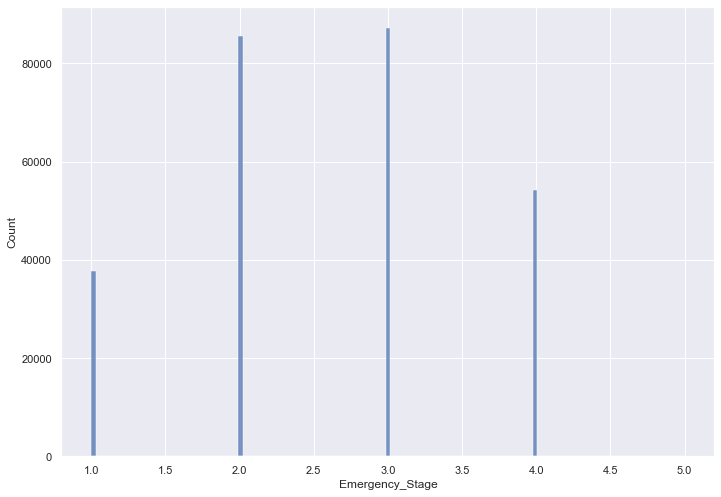

In [275]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(x='Emergency_Stage', data=df6 )
plt.show()

In [276]:
df6.sample(10)

,Service,Emergency_Stage,Acquisition_Time,People_Waiting,lag_Waiting_Time_30_mn
41902,Cirurgia,4,2018-03-01 01:34:00,0,27.0
11645,Medicina,3,2017-11-29 06:32:00,1,17.0
85784,Medicina,4,2018-02-03 09:51:00,0,11.0
159561,Medicina,1,2018-02-06 17:40:00,0,256.0
138329,Cirurgia,3,2018-05-05 22:37:00,2,60.0
7352,Medicina,1,2017-11-24 10:19:00,0,196.0
196390,Medicina,4,2018-07-24 14:39:00,0,24.0
13965,Medicina,4,2017-01-12 23:33:00,0,6.0
37694,Cirurgia,2,2017-12-29 07:09:00,1,57.0
238295,Medicina,3,2018-09-19 12:31:00,2,9.0


In [277]:
df6['Acquisition_Time'] = pd.to_datetime(df['Acquisition_Time'])

In [278]:
### Simple linear model with only two engineered features

def get_hour_and_weekday(x):
    x['weekday'] = float(x['Acquisition_Time'].weekday() < 6) # Mon:0,Tue:1,...,Sat:6,Sun:7
    x['hour'] = x['Acquisition_Time'].hour
    return x


model = (compose.Select('Service') | preprocessing.OneHotEncoder())
model += compose.Select('Emergency_Stage','lag_Waiting_Time_30_mn')
model += (get_hour_and_weekday |
    feature_extraction.TargetAgg(by='hour', how=stats.Mean()))

model |= preprocessing.StandardScaler()
model |= linear_model.LinearRegression(optimizer=optim.SGD(0.001))

metric = metrics.MAE()
model

Pipeline (
  TransformerUnion (
    Pipeline (
      Select (
        Service
      ),
      OneHotEncoder (
        sparse=False
      )
    ),
    Select (
      Emergency_Stage
      lag_Waiting_Time_30_mn
    ),
    Pipeline (
      FuncTransformer (
        func="get_hour_and_weekday"
      ),
      TargetAgg (
        by=['hour']
        how=Mean ()
        target_name="y"
      )
    )
  ),
  StandardScaler (
    with_std=True
  ),
  LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.001
      )
    )
    loss=Squared ()
    l2=0.
    l1=0.
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  )
)

In [279]:
evaluate.progressive_val_score(
    dataset= stream.iter_pandas(df6,y),
    model=model,
    metric=metric,
    moment='Acquisition_Time',
    delay=dt.timedelta(minutes=30),
    print_every=20_000
)


[20,000] MAE: 14.689964
[40,000] MAE: 15.437525
[60,000] MAE: 17.385511
[80,000] MAE: 19.250905
[100,000] MAE: 19.31717
[120,000] MAE: 19.195699
[140,000] MAE: 19.373668
[160,000] MAE: 19.533404
[180,000] MAE: 18.83834
[200,000] MAE: 18.06812
[220,000] MAE: 17.684765
[240,000] MAE: 17.391155
[260,000] MAE: 17.230256


MAE: 17.1294

In [280]:
model = (compose.Select('Service') | preprocessing.OneHotEncoder())
model += compose.Select('Emergency_Stage','lag_Waiting_Time_30_mn', 'People_Waiting')
model += (get_hour_and_weekday |
    feature_extraction.TargetAgg(by=['hour', 'weekday'], how=stats.Mean()))

model |= preprocessing.StandardScaler()
model |= linear_model.LinearRegression(optimizer=optim.SGD(0.001))

metric = metrics.MAE()
model

Pipeline (
  TransformerUnion (
    Pipeline (
      Select (
        Service
      ),
      OneHotEncoder (
        sparse=False
      )
    ),
    Select (
      Emergency_Stage
      People_Waiting
      lag_Waiting_Time_30_mn
    ),
    Pipeline (
      FuncTransformer (
        func="get_hour_and_weekday"
      ),
      TargetAgg (
        by=['hour', 'weekday']
        how=Mean ()
        target_name="y"
      )
    )
  ),
  StandardScaler (
    with_std=True
  ),
  LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.001
      )
    )
    loss=Squared ()
    l2=0.
    l1=0.
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  )
)

In [281]:
evaluate.progressive_val_score(
    dataset= stream.iter_pandas(df6,y),
    model=model,
    metric=metric,
    moment='Acquisition_Time',
    delay=dt.timedelta(minutes=30),
    print_every=20_000
)

[20,000] MAE: 15.409946
[40,000] MAE: 15.865384
[60,000] MAE: 17.251659
[80,000] MAE: 18.691369
[100,000] MAE: 18.680015
[120,000] MAE: 18.599414
[140,000] MAE: 18.797329
[160,000] MAE: 18.973901
[180,000] MAE: 18.275402
[200,000] MAE: 17.675246
[220,000] MAE: 17.444513
[240,000] MAE: 17.292571
[260,000] MAE: 17.263846


MAE: 17.194201

In [282]:
model = compose.Select('Emergency_Stage','lag_Waiting_Time_30_mn','People_Waiting') 
model += (get_hour_and_weekday |
    feature_extraction.TargetAgg(by=['Service', 'hour', 'weekday'], how=stats.Mean()))

model |= preprocessing.StandardScaler()
model |= linear_model.LinearRegression(optimizer=optim.SGD(0.001))

metric = metrics.MAE()
model

Pipeline (
  TransformerUnion (
    Select (
      Emergency_Stage
      People_Waiting
      lag_Waiting_Time_30_mn
    ),
    Pipeline (
      FuncTransformer (
        func="get_hour_and_weekday"
      ),
      TargetAgg (
        by=['Service', 'hour', 'weekday']
        how=Mean ()
        target_name="y"
      )
    )
  ),
  StandardScaler (
    with_std=True
  ),
  LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.001
      )
    )
    loss=Squared ()
    l2=0.
    l1=0.
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  )
)

In [283]:
evaluate.progressive_val_score(
    dataset= stream.iter_pandas(df6,y),
    model=model,
    metric=metric,
    moment='Acquisition_Time',
    delay=dt.timedelta(minutes=30),
    print_every=20_000
)

[20,000] MAE: 14.347626
[40,000] MAE: 14.767305
[60,000] MAE: 16.297227
[80,000] MAE: 17.855983
[100,000] MAE: 17.87738
[120,000] MAE: 17.85168
[140,000] MAE: 18.076716
[160,000] MAE: 18.282093
[180,000] MAE: 17.595217
[200,000] MAE: 17.037826
[220,000] MAE: 16.853754
[240,000] MAE: 16.731064
[260,000] MAE: 16.716589


MAE: 16.650393

In [284]:
model = compose.Select('Emergency_Stage','lag_Waiting_Time_30_mn','People_Waiting') 
model += (get_hour_and_weekday |
    feature_extraction.TargetAgg(by=['Service', 'hour', 'weekday'], how=stats.Mean()))

model |= preprocessing.StandardScaler()
model |= ensemble.EWARegressor([ # <- This ensemble regressor will combine 
                                # 3 linear regression models trained with different optimizers. 
    linear_model.LinearRegression(optim.SGD()), # The EWARegressor will run the 3 models in parallel 
    linear_model.LinearRegression(optim.RMSProp()),# and assign weights to each model based on their individual performance.
    linear_model.LinearRegression(optim.Adam())
])

metric = metrics.MAE()
model

Pipeline (
  TransformerUnion (
    Select (
      Emergency_Stage
      People_Waiting
      lag_Waiting_Time_30_mn
    ),
    Pipeline (
      FuncTransformer (
        func="get_hour_and_weekday"
      ),
      TargetAgg (
        by=['Service', 'hour', 'weekday']
        how=Mean ()
        target_name="y"
      )
    )
  ),
  StandardScaler (
    with_std=True
  ),
  [LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=0.
    l1=0.
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  ), LinearRegression (
    optimizer=RMSProp (
      lr=Constant (
        learning_rate=0.1
      )
      rho=0.9
      eps=1e-08
    )
    loss=Squared ()
    l2=0.
    l1=0.
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  ), LinearRegression (
    optimizer=Adam (
      lr=Constant (
        learning_rate=0.1
      )
      beta_1=0.9
      beta_2=0.999
      eps=1e-08
    )
    loss=Squared ()
    l2=0.
    l1=0.
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  )]
)

In [285]:
evaluate.progressive_val_score(
    dataset= stream.iter_pandas(df6,y),
    model=model,
    metric=metric,
    moment='Acquisition_Time',
    delay=dt.timedelta(minutes=30),
    print_every=20_000
)

[20,000] MAE: 56.4166
[40,000] MAE: 62.559175
[60,000] MAE: 63.4244
[80,000] MAE: 66.7776
[100,000] MAE: 67.14619
[120,000] MAE: 66.472525
[140,000] MAE: 66.294857
[160,000] MAE: 65.949156
[180,000] MAE: 65.149583
[200,000] MAE: 64.954845
[220,000] MAE: 65.087832
[240,000] MAE: 65.304767
[260,000] MAE: 65.864504


MAE: 65.827651

In [286]:
model = compose.Select('Emergency_Stage','lag_Waiting_Time_30_mn','People_Waiting') 
model += (get_hour_and_weekday |
    feature_extraction.TargetAgg(by=['Service', 'hour', 'weekday'], how=stats.Mean()))


model |= preprocessing.StandardScaler()
model |= ensemble.BaggingRegressor(
     model=linear_model.LinearRegression(intercept_lr=0.1),
     n_models=3,
     seed=42
)

metric = metrics.MAE()
model


Pipeline (
  TransformerUnion (
    Select (
      Emergency_Stage
      People_Waiting
      lag_Waiting_Time_30_mn
    ),
    Pipeline (
      FuncTransformer (
        func="get_hour_and_weekday"
      ),
      TargetAgg (
        by=['Service', 'hour', 'weekday']
        how=Mean ()
        target_name="y"
      )
    )
  ),
  StandardScaler (
    with_std=True
  ),
  [LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=0.
    l1=0.
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.1
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  ), LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=0.
    l1=0.
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.1
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  ), LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=0.
    l1=0.
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.1
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  )]
)

In [287]:
evaluate.progressive_val_score(
    dataset= stream.iter_pandas(df6,y),
    model=model,
    metric=metric,
    moment='Acquisition_Time',
    delay=dt.timedelta(minutes=30),
    print_every=20_000
)

[20,000] MAE: 16.496468
[40,000] MAE: 17.74545
[60,000] MAE: 21.722871
[80,000] MAE: 26.387572
[100,000] MAE: 26.270544
[120,000] MAE: 25.604584
[140,000] MAE: 25.22218
[160,000] MAE: 25.123981
[180,000] MAE: 23.854074
[200,000] MAE: 22.544684
[220,000] MAE: 21.73068
[240,000] MAE: 21.075281
[260,000] MAE: 20.609732


MAE: 20.443075

In [288]:
model = (compose.Select('Service') | preprocessing.OneHotEncoder())
model += compose.Select('Emergency_Stage','lag_Waiting_Time_30_mn')
model += (get_hour_and_weekday |
    feature_extraction.TargetAgg(by='hour', how=stats.Mean()))

model |= preprocessing.StandardScaler()
model |= ensemble.EWARegressor([ # <- This ensemble regressor will combine 
                                # 3 linear regression models trained with different optimizers. 
    linear_model.LinearRegression(optim.SGD()), # The EWARegressor will run the 3 models in parallel 
    linear_model.LinearRegression(optim.RMSProp()),# and assign weights to each model based on their individual performance.
    linear_model.LinearRegression(optim.Adam()),
    neighbors.KNNRegressor(window_size=50)
])

metric = metrics.MAE()
model


Pipeline (
  TransformerUnion (
    Pipeline (
      Select (
        Service
      ),
      OneHotEncoder (
        sparse=False
      )
    ),
    Select (
      Emergency_Stage
      lag_Waiting_Time_30_mn
    ),
    Pipeline (
      FuncTransformer (
        func="get_hour_and_weekday"
      ),
      TargetAgg (
        by=['hour']
        how=Mean ()
        target_name="y"
      )
    )
  ),
  StandardScaler (
    with_std=True
  ),
  [LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=0.
    l1=0.
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  ), LinearRegression (
    optimizer=RMSProp (
      lr=Constant (
        learning_rate=0.1
      )
      rho=0.9
      eps=1e-08
    )
    loss=Squared ()
    l2=0.
    l1=0.
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  ), LinearRegression (
    optimizer=Adam (
      lr=Constant (
        learning_rate=0.1
      )
      beta_1=0.9
      beta_2=0.999
      eps=1e-08
    )
    loss=Squared ()
    l2=0.
    l1=0.
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  ), KNNRegressor (
    n_neighbors=5
    window_size=50
    aggregation_method="mean"
    min_distance_keep=0.
    distance_func=None
  )]
)

In [289]:
evaluate.progressive_val_score(
    dataset= stream.iter_pandas(df6,y),
    model=model,
    metric=metric,
    moment='Acquisition_Time',
    delay=dt.timedelta(minutes=30),
    print_every=20_000
)

[20,000] MAE: 56.4166
[40,000] MAE: 62.559175
[60,000] MAE: 63.4244
[80,000] MAE: 66.7776
[100,000] MAE: 67.14619
[120,000] MAE: 66.472525
[140,000] MAE: 66.294857
[160,000] MAE: 65.949156
[180,000] MAE: 65.149583
[200,000] MAE: 64.954845
[220,000] MAE: 65.087832
[240,000] MAE: 65.304767
[260,000] MAE: 65.864504


MAE: 65.827651

In [290]:
model = compose.Select('Emergency_Stage','lag_Waiting_Time_30_mn','People_Waiting') 
model += (get_hour_and_weekday |
    feature_extraction.TargetAgg(by=['Service', 'hour', 'weekday'], how=stats.Mean()))

model |= preprocessing.StandardScaler()
model |= (
     preprocessing.StandardScaler() |
     tree.HoeffdingAdaptiveTreeRegressor(
         grace_period=50,
         leaf_prediction='adaptive',
         model_selector_decay=0.3,
         seed=0
     )
 )
 
metric = metrics.MAE()
model

Pipeline (
  TransformerUnion (
    Select (
      Emergency_Stage
      People_Waiting
      lag_Waiting_Time_30_mn
    ),
    Pipeline (
      FuncTransformer (
        func="get_hour_and_weekday"
      ),
      TargetAgg (
        by=['Service', 'hour', 'weekday']
        how=Mean ()
        target_name="y"
      )
    )
  ),
  StandardScaler (
    with_std=True
  ),
  Pipeline (
    StandardScaler (
      with_std=True
    ),
    HoeffdingAdaptiveTreeRegressor (
      grace_period=50
      max_depth=inf
      split_confidence=1e-07
      tie_threshold=0.05
      leaf_prediction="adaptive"
      leaf_model=LinearRegression (
        optimizer=SGD (
          lr=Constant (
            learning_rate=0.01
          )
        )
        loss=Squared ()
        l2=0.
        l1=0.
        intercept_init=0.
        intercept_lr=Constant (
          learning_rate=0.01
        )
        clip_gradient=1e+12
        initializer=Zeros ()
      )
      model_selector_decay=0.3
      nominal_attributes=None
      splitter=EBSTSplitter ()
      min_samples_split=5
      bootstrap_sampling=True
      drift_window_threshold=300
      adwin_confidence=0.002
      binary_split=False
      max_size=500.
      memory_estimate_period=1000000
      stop_mem_management=False
      remove_poor_attrs=False
      merit_preprune=True
      seed=0
    )
  )
)

In [291]:
evaluate.progressive_val_score(
    dataset= stream.iter_pandas(df6,y),
    model=model,
    metric=metric,
    moment='Acquisition_Time',
    delay=dt.timedelta(minutes=30),
    print_every=20_000
)

[20,000] MAE: 18.603367
[40,000] MAE: 19.145109
[60,000] MAE: 21.069427
[80,000] MAE: 23.216357
[100,000] MAE: 23.043719
[120,000] MAE: 22.249255
[140,000] MAE: 21.989088
[160,000] MAE: 21.749552
[180,000] MAE: 20.637186
[200,000] MAE: 20.078078
[220,000] MAE: 20.013212
[240,000] MAE: 20.027874
[260,000] MAE: 20.112975


MAE: 20.039098

In [292]:
model = compose.Select('Emergency_Stage','lag_Waiting_Time_30_mn','People_Waiting') 
model += (get_hour_and_weekday |
    feature_extraction.TargetAgg(by=['Service', 'hour', 'weekday'], how=stats.Mean()))

model |= preprocessing.StandardScaler()
model |= (
     preprocessing.StandardScaler() |
     tree.HoeffdingTreeRegressor(
         grace_period=100,
         leaf_prediction='adaptive',
         model_selector_decay=0.9
     )
 )
 
metric = metrics.MAE()
model

Pipeline (
  TransformerUnion (
    Select (
      Emergency_Stage
      People_Waiting
      lag_Waiting_Time_30_mn
    ),
    Pipeline (
      FuncTransformer (
        func="get_hour_and_weekday"
      ),
      TargetAgg (
        by=['Service', 'hour', 'weekday']
        how=Mean ()
        target_name="y"
      )
    )
  ),
  StandardScaler (
    with_std=True
  ),
  Pipeline (
    StandardScaler (
      with_std=True
    ),
    HoeffdingTreeRegressor (
      grace_period=100
      max_depth=inf
      split_confidence=1e-07
      tie_threshold=0.05
      leaf_prediction="adaptive"
      leaf_model=LinearRegression (
        optimizer=SGD (
          lr=Constant (
            learning_rate=0.01
          )
        )
        loss=Squared ()
        l2=0.
        l1=0.
        intercept_init=0.
        intercept_lr=Constant (
          learning_rate=0.01
        )
        clip_gradient=1e+12
        initializer=Zeros ()
      )
      model_selector_decay=0.9
      nominal_attributes=None
      splitter=EBSTSplitter ()
      min_samples_split=5
      binary_split=False
      max_size=500.
      memory_estimate_period=1000000
      stop_mem_management=False
      remove_poor_attrs=False
      merit_preprune=True
    )
  )
)

In [293]:
evaluate.progressive_val_score(
    dataset= stream.iter_pandas(df6,y),
    model=model,
    metric=metric,
    moment='Acquisition_Time',
    delay=dt.timedelta(minutes=30),
    print_every=20_000
)

[20,000] MAE: 17.226146
[40,000] MAE: 17.100041
[60,000] MAE: 16.970837
[80,000] MAE: 17.433353
[100,000] MAE: 17.276198
[120,000] MAE: 17.247435
[140,000] MAE: 17.497743
[160,000] MAE: 17.69115
[180,000] MAE: 16.997278
[200,000] MAE: 16.690794
[220,000] MAE: 16.844797
[240,000] MAE: 16.96
[260,000] MAE: 17.150182


MAE: 17.13027

In [294]:
model = compose.Select('Emergency_Stage','lag_Waiting_Time_30_mn','People_Waiting') 
model += (get_hour_and_weekday |
    feature_extraction.TargetAgg(by=['Service', 'hour', 'weekday'], how=stats.Mean()))

model |= preprocessing.StandardScaler()
model |= tree.SGTRegressor(
     delta=0.01,
     lambda_value=0.01,
     grace_period=20,
 )
 
metric = metrics.MAE()
model

Pipeline (
  TransformerUnion (
    Select (
      Emergency_Stage
      People_Waiting
      lag_Waiting_Time_30_mn
    ),
    Pipeline (
      FuncTransformer (
        func="get_hour_and_weekday"
      ),
      TargetAgg (
        by=['Service', 'hour', 'weekday']
        how=Mean ()
        target_name="y"
      )
    )
  ),
  StandardScaler (
    with_std=True
  ),
  SGTRegressor (
    delta=0.01
    grace_period=20
    init_pred=0.
    max_depth=inf
    lambda_value=0.01
    gamma=1.
    nominal_attributes=[]
    feature_quantizer=StaticQuantizer (
      n_bins=64
      warm_start=100
      buckets=None
    )
  )
)

In [295]:
evaluate.progressive_val_score(
    dataset= stream.iter_pandas(df6,y),
    model=model,
    metric=metric,
    moment='Acquisition_Time',
    delay=dt.timedelta(minutes=30),
    print_every=20_000
)

[20,000] MAE: 17.52268
[40,000] MAE: 18.379462
[60,000] MAE: 18.311202
[80,000] MAE: 19.362971
[100,000] MAE: 19.037141
[120,000] MAE: 18.559262
[140,000] MAE: 18.438638
[160,000] MAE: 18.294061
[180,000] MAE: 17.515717
[200,000] MAE: 17.2175
[220,000] MAE: 17.249521
[240,000] MAE: 17.294605
[260,000] MAE: 17.451791


MAE: 17.405394